<a href="https://colab.research.google.com/github/eduardoplima/rl-imd/blob/main/relatorio_aprendizado_reforco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizado por Reforço - Avaliação Final


O aprendizado por reforço é uma subárea da inteligência artificial que busca treinar agentes para tomar decisões em ambientes interativos com o objetivo de maximizar uma recompensa acumulada ao longo do tempo. Diferente de métodos supervisionados, onde há dados rotulados para guiar o aprendizado, no aprendizado por reforço o agente explora o ambiente por meio de tentativa e erro, ajustando suas ações com base no feedback recebido na forma de recompensas ou penalidades. Esse processo ocorre em um ciclo contínuo de interação, no qual o agente observa o estado do ambiente, toma uma ação, recebe uma recompensa e atualiza sua estratégia, aprendendo gradualmente a executar comportamentos que levam a melhores resultados.

Dentre os algoritmos mais conhecidos de aprendizado por reforço estão o SARSA e o Q-Learning, que utilizam a chamada tabela Q para armazenar e atualizar os valores associados a pares de estado e ação. O SARSA (State-Action-Reward-State-Action) é um algoritmo on-policy, o que significa que ele atualiza os valores Q com base na política atual, considerando a sequência de ações efetivamente escolhidas pelo agente. Já o Q-Learning é um método off-policy, onde a atualização dos valores Q se baseia na ação com maior recompensa esperada, independentemente da política seguida no momento. Enquanto o SARSA tende a ser mais conservador e adequado para cenários com riscos elevados, o Q-Learning é mais exploratório e busca estratégias otimizadas globalmente, sendo amplamente utilizado em diversas aplicações, como jogos, controle de sistemas e robótica.

Nesse notebook estão exemplos de aplicações com ambas as técnicas na biblioteca python Gymnasium. Os ambientes explorados são o `Frozen Lake`, onde o agente precisa alcançar um objetivo sem cair em buracos em um ambiente baseado em grade, e o `Cart Pole`, cujo objetivo é balancear um pêndulo invertido sobre um carrinho movendo-o para a esquerda ou direita.

## `Frozen Lake`

No `Frozen Lake`, o objetivo é atravessar um lago congelado do ponto S ao objetivo G sem cair em qualquer buraco H ao longo dos espaço F do território. Se a natureza do ambiente for escorregadia (`slippery`), o agente pode tomar direções não calculadas.

O agente recebe 1 vetor para suas ações. O espaço de ação é definido por `(dir)`, que define a direção a seguir a partir das opções:

* 0: ESQUERDA
* 1: ABAIXO
* 2: DIREITA
* 3: ACIMA

A observação é um valor que represente a posição atual do agente e é definido por `current_row * nrows + current_col`, ou seja, a linha atual vezes a quantidade de linhas mais a coluna atual.

As recompensas são definidas como:

* Objetivo(G): +1
* Buraco(H): 0
* Congelado(F): 0

### Configuração do ambiente

In [129]:
%%capture
!pip install gymnasium
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!apt-get install -y python-opengl ffmpeg
!pip install pytorch

In [130]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd

In [131]:

from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [132]:
from gym.envs.toy_text.frozen_lake import generate_random_map

# Criação e inspeção do ambiente Frozen Lake.
side_map_size = 8
proba_frozen = 0.9

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="rgb_array", desc=generate_random_map(size=side_map_size, p=proba_frozen))
env.spec

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


EnvSpec(id='FrozenLake-v1', entry_point='gymnasium.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, disable_env_checker=False, kwargs={'map_name': '4x4', 'is_slippery': False, 'render_mode': 'rgb_array', 'desc': ['SFFFFFFF', 'FFFFFFFF', 'HFFFHHFF', 'FFFFHFFF', 'FFFFFFFF', 'FHFFFFFF', 'FFFFFFFF', 'FFFFFFFG']}, namespace=None, name='FrozenLake', version=1, additional_wrappers=(), vector_entry_point=None)

In [133]:
actions = ["move left", "move down", "move right", "move up"]
print ("Actions:", actions)

Actions: ['move left', 'move down', 'move right', 'move up']


In [134]:
def plot_image(plot, render, size):
  plot.figure(figsize=(14, 5))
  plot.xticks(range(size))
  plot.yticks(range(size))
  plot.imshow(render, extent=[0, size, size, 0])
  plot.show()

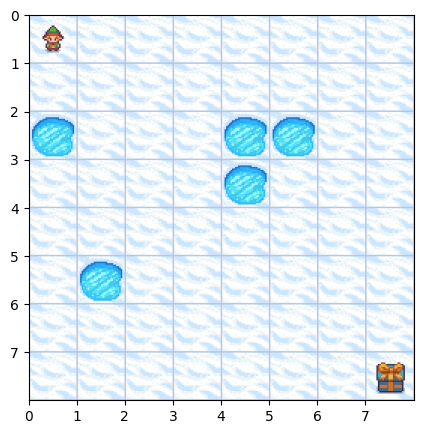

In [135]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the frozenlake gridworld
env.reset()
img = env.render()
plot_image(plt,img,int(np.sqrt(env.observation_space.n)))

Executamos ações aleatórias para testar o ambiente

In [136]:
print("passo número : ação, posição, recompensa, terminado, truncado, {info}")

for i in range(20):
    # Amostra aleatória de ação válida
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("passo", i+1, ":", action, ",", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

passo número : ação, posição, recompensa, terminado, truncado, {info}
passo 1 : 0 , move left , 0 , 0.0 , False , False , {'prob': 1.0}
passo 2 : 1 , move down , 8 , 0.0 , False , False , {'prob': 1.0}
passo 3 : 1 , move down , 16 , 0.0 , True , False , {'prob': 1.0}


In [137]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

state, info = env.reset()
env.render()
video.capture_frame()

for i in range(100):
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    env.render()
    video.capture_frame()

    if(is_terminal):
        print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
        break

video.close()

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 77 : move right , 28 , 0.0 , True , False , {'prob': 1.0}


In [138]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Criando uma estratégia SARSA ou Q-Learning tabular para o Frozen Lake

A classe a seguir

In [139]:
class FrozenLakeAgent:
    def __init__(
        self,
        alpha_learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        gamma_discount_factor: float,
        state_size: int,
        action_size: int,
        is_using_Sarsa: bool
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_table), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_size: The state space
            action_size: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_size = state_size
        self.action_size = action_size
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []
        self.q_table = np.zeros((self.state_size, self.action_size))

        if(self.is_using_Sarsa):
            print("Using Sarsa method")
        else:
            print("Using Q-learning method")

        # Set the seed
        self.rng = np.random.default_rng(100785)

    def get_Q_Table(self):
        return self.q_table

    def eval_state(self, state):
        # Break ties randomly
        # Find the indices where the Q-value equals the maximum value
        # Choose a random action from the indices where the Q-value is maximum
        max_ids = np.where(self.q_table[state, :] == np.max(self.q_table[state, :]))[0]
        return self.rng.choice(max_ids)

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return env.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the Q-value of an action."""
        if terminated:
            target = reward
        else:
            # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
            if(self.is_using_Sarsa):
                target = reward + self.gamma_discount_factor * self.q_table[next_state, next_action]

            # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            else:
                target = reward + self.gamma_discount_factor * np.max(self.q_table[next_state, :])

        temporal_difference_error = target - self.q_table[state, action]

        # Train the agent using target and the predicted q_table values
        self.q_table[state, action] = self.q_table[state, action] + self.alpha_learning_rate * temporal_difference_error

        self.training_error.append(temporal_difference_error)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [140]:
def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

In [141]:
def record_trained_video(agent, video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

In [176]:
def save_imgs(training_error, rewards, accuracies, steps, filename):
  rolling_length = 100
  fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
  axs[0].set_title("Training Reward")
  axs[0].set_xlabel('episode')
  axs[0].set_ylabel('reward')
  axs[0].bar(range(len(rewards)), rewards)

  axs[1].set_title("Test Reward")
  axs[1].set_xlabel('episode (x 50)')
  axs[1].set_ylabel('accuracy')
  axs[1].plot(range(len(accuracies)), accuracies)

  axs[2].set_title("Episode Length")
  axs[2].set_xlabel('episode')
  axs[2].set_ylabel('step')
  steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
  axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

  axs[3].set_title("Training Error")
  axs[3].set_xlabel('step')
  axs[3].set_ylabel('error')
  training_error_moving_average = np.convolve(np.array(training_error), np.ones(rolling_length), mode="same") / rolling_length
  axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [143]:
from tqdm import tqdm
def train_agent(agent, is_using_Sarsa):
  #Create lists to contain total rewards, steps and accurracy per episode
  accuracies = []
  mean_rewards = []
  rewards = []
  steps = []
  total_steps = 0

  for episode_count in tqdm(range(nb_max_episodes)):
      state, info = env.reset()
      is_terminal = False
      total_reward = 0
      episode_step = 0

      if(is_using_Sarsa): # Sarsa
          # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
          action = agent.choose_action(state)

      # The Q-Table training
      while not is_terminal:
          episode_step += 1

          if(not is_using_Sarsa): # Q-learning
              # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
              action = agent.choose_action(state)

          # Play best or random move and get new state and reward from environment
          next_state, reward, terminated, truncated, info = env.step(action)
          is_terminal = terminated or truncated

          # update the agent
          if(not is_using_Sarsa): # Q-learning
              agent.update(state, action, reward, terminated, next_state, None)
          else: # Sarsa
              next_action = agent.choose_action(next_state)
              agent.update(state, action, reward, terminated, next_state, next_action)
              action = next_action

          # update the current observation
          state = next_state
          total_steps += 1
          total_reward += reward

      agent.decay_epsilon()

      mean_rewards.append(total_reward)
      if (episode_count+1) % test_freq == 0:
          accur = test_accurracy(agent, env.spec.max_episode_steps,50)
          accuracies.append(accur)

          print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
          mean_rewards.clear()

      rewards.append(total_reward)
      steps.append(episode_step)

  after_training = "after_training_sarsa.mp4" if is_using_Sarsa else "after_training_q.mp4"
  record_trained_video(agent, after_training, env.spec.max_episode_steps)
  env.close()
  return after_training, rewards, steps, accuracies



In [144]:
# hyperparameters
alpha_learning_rate = 0.5 # @param {type:"number"}
nb_max_episodes = 10000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

agent_sarsa = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = True
)

agent_q = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = False
)


Using Sarsa method
Using Q-learning method


In [156]:
from itertools import product

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [205]:
alphas = [0.2, 0.5, 0.9]
epsilons = [0.2, 0.5, 0.9]
gammas = [0.2, 0.5, 0.9]

In [206]:
len(list(product(*[alphas, epsilons, gammas])))

27

In [ ]:
df_experiments = pd.DataFrame(columns=['alpha', 'epsilon', 'gamma', 'accuracy', 'rewards', 'steps', 'error', 'agent'])

for alpha in alphas:
    for epsilon in epsilons:
        for gamma_discount_factor in gammas:
            print(f'Rodando alpha {alpha} e epsilon {epsilon}')
            agent_sarsa = FrozenLakeAgent(
                alpha_learning_rate=alpha,
                initial_epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=gamma_discount_factor,
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = True
            )

            agent_q = FrozenLakeAgent(
                alpha_learning_rate=alpha,
                initial_epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=gamma_discount_factor,
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = False
            )

            after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
            error = agent_sarsa.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_sarsa],
                                                                      'rewards': [rewards_sarsa],
                                                                      'steps': [steps_sarsa],
                                                                      'error': [error],
                                                                      'agent': ['tabular_sarsa']})])
            after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
            error = agent_q.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_q],
                                                                      'rewards': [rewards_q],
                                                                      'steps': [steps_q],
                                                                      'error': [error],
                                                                      'agent': ['tabular_q']})])
            print(f'Len experiments {len(df_experiments)}')


Rodando alpha 0.2 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 184/10000 [00:00<00:21, 457.98it/s]

step: 2196, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 292/10000 [00:00<00:21, 444.67it/s]

step: 4032, episode: 200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▍         | 400/10000 [00:00<00:23, 412.35it/s]

step: 6095, episode: 300, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.18799999999999634
step: 7989, episode: 400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1839999999999951


  6%|▌         | 579/10000 [00:01<00:19, 477.31it/s]

step: 9911, episode: 500, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.1799999999999939


  7%|▋         | 700/10000 [00:01<00:19, 482.40it/s]

step: 11884, episode: 600, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.17599999999999266
step: 13675, episode: 700, accuracy training: 0.07, accuracy test: 0.42, random move probability: 0.17199999999999144


  9%|▉         | 900/10000 [00:01<00:13, 680.79it/s]

step: 15364, episode: 800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 17013, episode: 900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1100/10000 [00:02<00:11, 788.44it/s]

step: 18671, episode: 1000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 20213, episode: 1100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1300/10000 [00:02<00:10, 857.42it/s]

step: 21822, episode: 1200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 23431, episode: 1300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1500/10000 [00:02<00:10, 846.67it/s]

step: 25023, episode: 1400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 26617, episode: 1500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1700/10000 [00:02<00:09, 855.96it/s]

step: 28161, episode: 1600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 29721, episode: 1700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1900/10000 [00:02<00:08, 905.63it/s]

step: 31238, episode: 1800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 32740, episode: 1900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 34229, episode: 2000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2200/10000 [00:03<00:08, 921.66it/s]

step: 35801, episode: 2100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 37322, episode: 2200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2400/10000 [00:03<00:08, 895.37it/s]

step: 38921, episode: 2300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 40436, episode: 2400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2600/10000 [00:03<00:08, 873.02it/s]

step: 41909, episode: 2500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 43407, episode: 2600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:03<00:07, 910.89it/s]

step: 44980, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 46484, episode: 2800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:04<00:07, 900.58it/s]

step: 47972, episode: 2900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 49478, episode: 3000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3200/10000 [00:04<00:07, 915.21it/s]

step: 51031, episode: 3100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 52531, episode: 3200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3400/10000 [00:04<00:07, 899.80it/s]

step: 54077, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 55565, episode: 3400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3700/10000 [00:04<00:06, 924.70it/s]

step: 57094, episode: 3500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 58610, episode: 3600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 60118, episode: 3700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:05<00:06, 926.05it/s]

step: 61620, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 63139, episode: 3900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:05<00:06, 913.74it/s]

step: 64666, episode: 4000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 66192, episode: 4100, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:05<00:06, 900.77it/s]

step: 67720, episode: 4200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 69256, episode: 4300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4500/10000 [00:05<00:06, 900.52it/s]

step: 70760, episode: 4400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 72282, episode: 4500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4700/10000 [00:06<00:05, 919.66it/s]

step: 73810, episode: 4600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 75328, episode: 4700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:06<00:05, 915.09it/s]

step: 76821, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 78283, episode: 4900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5100/10000 [00:06<00:05, 885.28it/s]

step: 79795, episode: 5000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 81310, episode: 5100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5300/10000 [00:06<00:05, 902.93it/s]

step: 82804, episode: 5200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 84257, episode: 5300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:06<00:04, 900.04it/s]

step: 85751, episode: 5400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 87279, episode: 5500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:07<00:04, 907.16it/s]

step: 88743, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 90194, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:07<00:04, 932.53it/s]

step: 91740, episode: 5800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 93275, episode: 5900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:07<00:04, 895.96it/s]

step: 94790, episode: 6000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 96313, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:07<00:04, 880.78it/s]

step: 97814, episode: 6200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 99322, episode: 6300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:08<00:03, 901.92it/s]

step: 100778, episode: 6400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 102327, episode: 6500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6700/10000 [00:08<00:03, 908.15it/s]

step: 103873, episode: 6600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 105410, episode: 6700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:08<00:03, 887.47it/s]

step: 106911, episode: 6800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 108401, episode: 6900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:08<00:03, 885.97it/s]

step: 109925, episode: 7000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 111449, episode: 7100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:08<00:03, 886.55it/s]

step: 112979, episode: 7200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 114484, episode: 7300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:09<00:02, 908.00it/s]

step: 116033, episode: 7400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 117529, episode: 7500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:09<00:02, 863.25it/s]

step: 119061, episode: 7600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 120610, episode: 7700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:09<00:02, 871.02it/s]

step: 122109, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 123602, episode: 7900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:09<00:02, 878.14it/s]

step: 125154, episode: 8000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 126601, episode: 8100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:10<00:01, 922.34it/s]

step: 128034, episode: 8200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 129517, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8500/10000 [00:10<00:01, 867.27it/s]

step: 131045, episode: 8400, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 132582, episode: 8500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8700/10000 [00:10<00:01, 848.55it/s]

step: 134073, episode: 8600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 135572, episode: 8700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8900/10000 [00:10<00:01, 884.94it/s]

step: 137078, episode: 8800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 138572, episode: 8900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9100/10000 [00:10<00:00, 902.90it/s]

step: 140139, episode: 9000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 141641, episode: 9100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9300/10000 [00:11<00:00, 918.30it/s]

step: 143103, episode: 9200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 144631, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9500/10000 [00:11<00:00, 887.29it/s]

step: 146156, episode: 9400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 147630, episode: 9500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9684/10000 [00:11<00:00, 785.33it/s]

step: 149053, episode: 9600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 150534, episode: 9700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9905/10000 [00:12<00:00, 636.59it/s]

step: 152019, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 153486, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:12<00:00, 814.92it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 155023, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


<ipython-input-210-016815bcd5a7>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
  2%|▏         | 166/10000 [00:00<00:21, 462.34it/s]

step: 2065, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 269/10000 [00:00<00:21, 452.74it/s]

step: 3990, episode: 200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.19199999999999756


  4%|▍         | 376/10000 [00:00<00:20, 475.11it/s]

step: 5896, episode: 300, accuracy training: 0.05, accuracy test: 0.04, random move probability: 0.18799999999999634


  5%|▌         | 500/10000 [00:01<00:21, 438.11it/s]

step: 7751, episode: 400, accuracy training: 0.05, accuracy test: 0.32, random move probability: 0.1839999999999951
step: 9211, episode: 500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 690/10000 [00:01<00:17, 523.86it/s]

step: 10740, episode: 600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 12203, episode: 700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▊         | 870/10000 [00:01<00:16, 552.30it/s]

step: 13650, episode: 800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 15176, episode: 900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1059/10000 [00:02<00:19, 460.94it/s]

step: 16689, episode: 1000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1154/10000 [00:02<00:22, 388.61it/s]

step: 18178, episode: 1100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1310/10000 [00:02<00:19, 441.66it/s]

step: 19633, episode: 1200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 21020, episode: 1300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▍        | 1491/10000 [00:03<00:13, 650.57it/s]

step: 22474, episode: 1400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 23959, episode: 1500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1745/10000 [00:03<00:10, 784.63it/s]

step: 25392, episode: 1600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 26877, episode: 1700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1913/10000 [00:03<00:09, 809.53it/s]

step: 28373, episode: 1800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 29940, episode: 1900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:03<00:09, 866.96it/s]

step: 31407, episode: 2000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 32831, episode: 2100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2300/10000 [00:04<00:09, 848.94it/s]

step: 34240, episode: 2200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 35713, episode: 2300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2500/10000 [00:04<00:08, 866.93it/s]

step: 37135, episode: 2400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 38590, episode: 2500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:04<00:08, 888.72it/s]

step: 40030, episode: 2600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 41460, episode: 2700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:04<00:07, 899.99it/s]

step: 42904, episode: 2800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 44317, episode: 2900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3100/10000 [00:04<00:07, 923.61it/s]

step: 45767, episode: 3000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 47255, episode: 3100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3300/10000 [00:05<00:07, 867.26it/s]

step: 48710, episode: 3200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 50129, episode: 3300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3500/10000 [00:05<00:07, 883.38it/s]

step: 51528, episode: 3400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 52997, episode: 3500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3803/10000 [00:05<00:06, 937.93it/s]

step: 54460, episode: 3600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 55807, episode: 3700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1
step: 57274, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4000/10000 [00:05<00:06, 930.34it/s]

step: 58642, episode: 3900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 60117, episode: 4000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4281/10000 [00:06<00:06, 874.10it/s]

step: 61664, episode: 4100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 63094, episode: 4200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 45%|████▍     | 4460/10000 [00:06<00:06, 877.05it/s]

step: 64572, episode: 4300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 66000, episode: 4400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 46%|████▋     | 4647/10000 [00:06<00:05, 904.46it/s]

step: 67445, episode: 4500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 68884, episode: 4600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4830/10000 [00:06<00:05, 891.27it/s]

step: 70320, episode: 4700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 71793, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5011/10000 [00:07<00:05, 835.84it/s]

step: 73269, episode: 4900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 74687, episode: 5000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5200/10000 [00:07<00:05, 856.18it/s]

step: 76127, episode: 5100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 77601, episode: 5200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5402/10000 [00:07<00:05, 904.76it/s]

step: 79001, episode: 5300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 80373, episode: 5400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5600/10000 [00:07<00:04, 911.18it/s]

step: 81813, episode: 5500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 83269, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5800/10000 [00:07<00:04, 917.67it/s]

step: 84739, episode: 5700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 86164, episode: 5800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5997/10000 [00:08<00:04, 924.65it/s]

step: 87555, episode: 5900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 89063, episode: 6000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6276/10000 [00:08<00:04, 918.18it/s]

step: 90483, episode: 6100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 91950, episode: 6200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6458/10000 [00:08<00:04, 847.23it/s]

step: 93392, episode: 6300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 94887, episode: 6400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 66%|██████▋   | 6626/10000 [00:08<00:04, 779.10it/s]

step: 96369, episode: 6500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 97820, episode: 6600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6798/10000 [00:09<00:03, 818.33it/s]

step: 99281, episode: 6700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 100753, episode: 6800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7056/10000 [00:09<00:03, 839.09it/s]

step: 102244, episode: 6900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 103722, episode: 7000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7235/10000 [00:09<00:03, 865.23it/s]

step: 105201, episode: 7100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 106641, episode: 7200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7417/10000 [00:09<00:02, 887.29it/s]

step: 108089, episode: 7300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 109506, episode: 7400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7600/10000 [00:10<00:02, 819.75it/s]

step: 110967, episode: 7500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 112457, episode: 7600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7846/10000 [00:10<00:02, 793.53it/s]

step: 113912, episode: 7700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 115412, episode: 7800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8010/10000 [00:10<00:02, 803.05it/s]

step: 116897, episode: 7900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 118366, episode: 8000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8200/10000 [00:10<00:02, 852.83it/s]

step: 119870, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 121346, episode: 8200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8400/10000 [00:11<00:01, 848.10it/s]

step: 122862, episode: 8300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 124356, episode: 8400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8667/10000 [00:11<00:01, 791.22it/s]

step: 125852, episode: 8500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 127333, episode: 8600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8836/10000 [00:11<00:01, 814.92it/s]

step: 128819, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 130288, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9011/10000 [00:11<00:01, 844.65it/s]

step: 131774, episode: 8900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 133245, episode: 9000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9184/10000 [00:12<00:01, 788.32it/s]

step: 134730, episode: 9100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 136232, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9400/10000 [00:12<00:01, 573.14it/s]

step: 137737, episode: 9300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 139193, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9600/10000 [00:12<00:00, 556.90it/s]

step: 140715, episode: 9500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 142198, episode: 9600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9800/10000 [00:13<00:00, 544.16it/s]

step: 143677, episode: 9700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 145163, episode: 9800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:13<00:00, 739.51it/s]

step: 146582, episode: 9900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 148120, episode: 10000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 2
Rodando alpha 0.2 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 188/10000 [00:00<00:18, 521.43it/s]

step: 2044, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  2%|▏         | 244/10000 [00:00<00:22, 427.49it/s]

step: 3881, episode: 200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▎         | 363/10000 [00:00<00:21, 448.41it/s]

step: 5882, episode: 300, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.18799999999999634


  5%|▍         | 481/10000 [00:01<00:20, 464.48it/s]

step: 7898, episode: 400, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.1839999999999951
step: 9715, episode: 500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 700/10000 [00:01<00:14, 631.72it/s]

step: 11589, episode: 600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 13294, episode: 700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 900/10000 [00:01<00:12, 756.74it/s]

step: 14826, episode: 800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 16416, episode: 900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.163999999999989


 12%|█▏        | 1180/10000 [00:01<00:10, 858.32it/s]

step: 17972, episode: 1000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 19492, episode: 1100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.15599999999998654


 14%|█▎        | 1350/10000 [00:02<00:10, 811.13it/s]

step: 21045, episode: 1200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 22544, episode: 1300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1534/10000 [00:02<00:09, 869.80it/s]

step: 24060, episode: 1400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 25615, episode: 1500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1715/10000 [00:02<00:09, 881.46it/s]

step: 27118, episode: 1600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 28620, episode: 1700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1900/10000 [00:02<00:09, 849.94it/s]

step: 30096, episode: 1800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 31650, episode: 1900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:03<00:09, 859.67it/s]

step: 33194, episode: 2000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 34713, episode: 2100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11599999999997743


 22%|██▏       | 2193/10000 [00:03<00:08, 875.42it/s]

In [ ]:
df_experiments['mean_accuracy'] = df_experiments['accuracy'].apply(lambda x: sum(x)/len(x))
df_experiments['mean_error'] = df_experiments['error'].apply(lambda x: sum(x)/len(x))
df_experiments['mean_steps'] = df_experiments['steps'].apply(lambda x: sum(x)/len(x))

In [198]:
df_sarsa = df_experiments[df_experiments.agent == 'tabular_sarsa']
df_q = df_experiments[df_experiments.agent == 'tabular_q']

In [ ]:
x = df_sarsa["alpha"]
y = df_sarsa["epsilon"]
z = df_sarsa["mean_accuracy"]
g = df_sarsa["gamma"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('alpha')
ax.set_ylabel('epsilon')
ax.set_zlabel('gamma')

ax.set_title('Gráfico de Dispersão 3D - Acurácia Média - Frozen Lake')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

In [200]:
df_q

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,alpha,epsilon,accuracy,rewards,steps,error,agent,mean_accuracy,mean_error,mean_steps
0,0.4,0.4,"[0.04, 0.0, 0.04, 0.04, 1.0, 1.0, 1.0, 1.0, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 6, 11, 8, 17, 6, 67, 5, 48, 3, 22, 29, 32,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tabular_q,0.9612,0.001870,16.0200
0,0.4,0.5,"[0.0, 0.02, 0.0, 0.04, 1.0, 1.0, 1.0, 1.0, 1.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8, 3, 13, 36, 7, 24, 27, 5, 7, 3, 5, 4, 15, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tabular_q,0.9606,0.001955,16.5893
0,0.4,0.6,"[0.0, 0.0, 0.0, 0.04, 0.02, 0.06, 1.0, 1.0, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 3, 14, 44, 11, 19, 12, 3, 13, 4, 5, 7, 3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tabular_q,0.9412,0.001979,17.3563
0,0.4,0.7,"[0.02, 0.0, 0.04, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9, 3, 3, 13, 24, 8, 28, 4, 24, 23, 10, 2, 15,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tabular_q,0.9616,0.002089,18.4560
0,0.5,0.4,"[0.02, 0.0, 0.04, 0.06, 0.3, 1.0, 1.0, 1.0, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3, 18, 6, 6, 11, 6, 48, 3, 27, 17, 3, 3, 15, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tabular_q,0.9542,0.001657,16.0348
0,0.5,0.5,"[0.02, 0.0, 0.04, 0.02, 1.0, 1.0, 1.0, 1.0, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3, 8, 2, 11, 66, 13, 2, 10, 9, 3, 4, 6, 78, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tabular_q,0.9608,0.001579,16.7561
0,0.5,0.6,"[0.0, 0.0, 0.32, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 14, 45, 27, 14, 60, 43, 18, 6, 8, 12, 12, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tabular_q,0.9732,0.001589,18.0747
0,0.5,0.7,"[0.0, 0.0, 0.04, 0.04, 0.14, 1.0, 1.0, 1.0, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5, 6, 2, 9, 15, 44, 22, 9, 19, 8, 7, 6, 13, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tabular_q,0.9522,0.001660,18.6064
0,0.6,0.4,"[0.0, 0.0, 0.04, 0.02, 0.0, 0.02, 1.0, 1.0, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3, 28, 24, 13, 10, 9, 7, 7, 14, 10, 21, 17, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tabular_q,0.9408,0.001287,15.9843
0,0.6,0.5,"[0.0, 0.0, 0.0, 0.02, 0.02, 0.02, 1.0, 1.0, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3, 11, 13, 32, 12, 7, 3, 17, 24, 5, 28, 2, 22...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tabular_q,0.9406,0.001509,16.5937


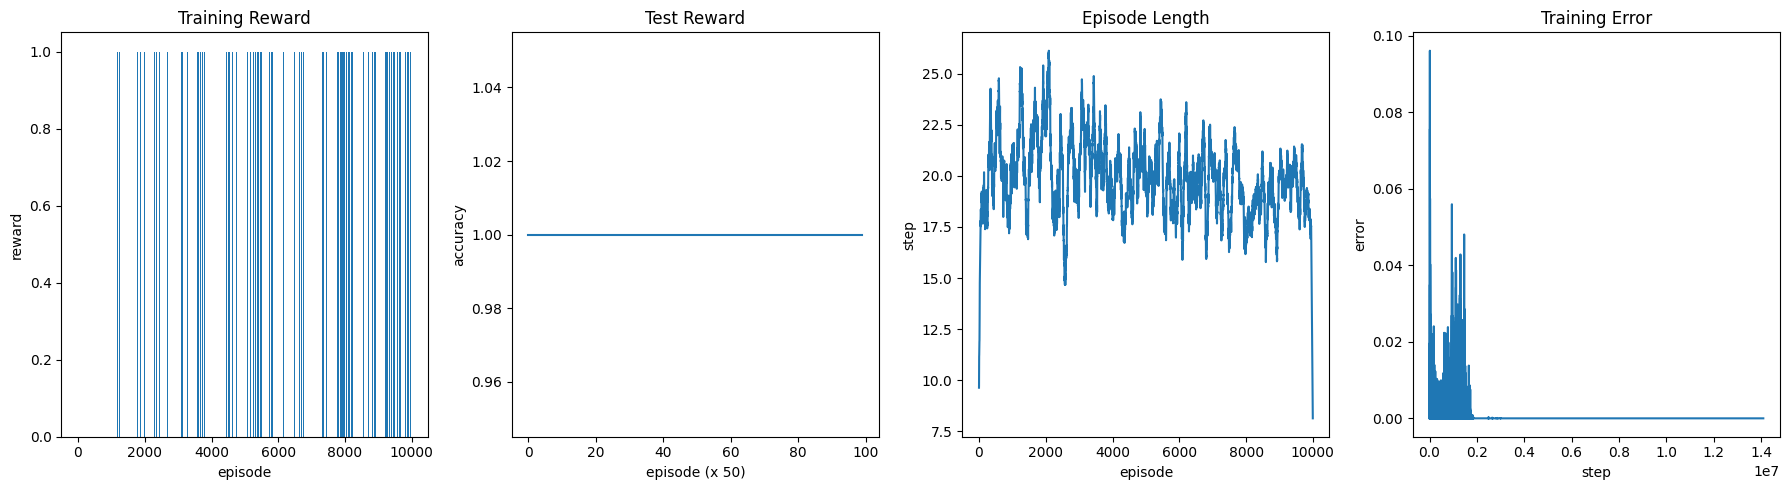

In [179]:
save_imgs(df_experiments.iloc[0].error, df_experiments.iloc[0].rewards, df_experiments.iloc[161].accuracy, df_experiments.iloc[161].steps,
          f'{df_experiments.iloc[161].agent}_{alpha}_{epsilon}.png')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [170]:
sum(df_experiments.iloc[1].accuracy)/len(df_experiments.iloc[1].accuracy)

1.0

<ipython-input-150-db9ebaf8bbe4>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],


,alpha,epsilon,accuracy,rewards,steps,error,agent
0,0.1,0.1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14, 15, 14, 14, 14, 17, 16, 15, 16, 6, 18, 18...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tabular_sarsa


In [175]:
df_experiments.to_pickle('df_experiments.pkl')

In [126]:
after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
html_sarsa = render_mp4(after_training_sarsa)
HTML(html_sarsa)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/2000 [00:00<?, ?it/s]


IndexError: arrays used as indices must be of integer (or boolean) type

In [87]:
after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
html_q = render_mp4(after_training_q)
HTML(html_q)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 191/10000 [00:00<00:19, 494.61it/s]

step: 4609, episode: 100, accuracy training: 0.06, accuracy test: 0.54, random move probability: 0.49600000000000155
step: 7476, episode: 200, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.4920000000000031


  4%|▍         | 400/10000 [00:00<00:15, 626.00it/s]

step: 10111, episode: 300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.48800000000000465
step: 12472, episode: 400, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 590/10000 [00:00<00:12, 738.21it/s]

step: 14645, episode: 500, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.48000000000000775
step: 16909, episode: 600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 801/10000 [00:01<00:14, 635.39it/s]

step: 19128, episode: 700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 21490, episode: 800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1024/10000 [00:01<00:12, 696.27it/s]

step: 23836, episode: 900, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 26081, episode: 1000, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1200/10000 [00:01<00:12, 730.07it/s]

step: 28231, episode: 1100, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 30426, episode: 1200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1422/10000 [00:02<00:12, 679.68it/s]

step: 32624, episode: 1300, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 34779, episode: 1400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1600/10000 [00:02<00:11, 728.19it/s]

step: 37066, episode: 1500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 39155, episode: 1600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1844/10000 [00:02<00:11, 727.72it/s]

step: 41308, episode: 1700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 43336, episode: 1800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2000/10000 [00:03<00:11, 705.65it/s]

step: 45486, episode: 1900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 47502, episode: 2000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2226/10000 [00:03<00:11, 700.25it/s]

step: 49723, episode: 2100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 51789, episode: 2200, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:03<00:10, 733.72it/s]

step: 54076, episode: 2300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 56058, episode: 2400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4040000000000372


 27%|██▋       | 2658/10000 [00:03<00:09, 772.51it/s]

step: 58142, episode: 2500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 60232, episode: 2600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2810/10000 [00:04<00:10, 656.66it/s]

step: 62345, episode: 2700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 64483, episode: 2800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3000/10000 [00:04<00:09, 728.45it/s]

step: 66574, episode: 2900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 68560, episode: 3000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3200/10000 [00:04<00:08, 768.53it/s]

step: 70531, episode: 3100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 72557, episode: 3200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3396/10000 [00:04<00:08, 824.53it/s]

step: 74507, episode: 3300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 76627, episode: 3400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▋      | 3635/10000 [00:05<00:08, 718.20it/s]

step: 78671, episode: 3500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 80673, episode: 3600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:05<00:08, 740.67it/s]

step: 82705, episode: 3700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 84664, episode: 3800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:05<00:07, 779.36it/s]

step: 86554, episode: 3900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 88383, episode: 4000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4198/10000 [00:05<00:07, 813.13it/s]

step: 90343, episode: 4100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 92304, episode: 4200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4438/10000 [00:06<00:07, 749.25it/s]

step: 94224, episode: 4300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 96120, episode: 4400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4600/10000 [00:06<00:07, 707.14it/s]

step: 98110, episode: 4500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 100077, episode: 4600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:06<00:06, 768.74it/s]

step: 101903, episode: 4700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 103783, episode: 4800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.30800000000007444


 51%|█████     | 5062/10000 [00:07<00:06, 767.36it/s]

step: 105688, episode: 4900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.304000000000076
step: 107552, episode: 5000, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5216/10000 [00:07<00:06, 732.17it/s]

step: 109422, episode: 5100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 111243, episode: 5200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:07<00:05, 781.25it/s]

step: 113123, episode: 5300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 114908, episode: 5400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:07<00:05, 819.91it/s]

step: 116671, episode: 5500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 118450, episode: 5600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5800/10000 [00:07<00:05, 809.37it/s]

step: 120227, episode: 5700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 122095, episode: 5800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6046/10000 [00:08<00:05, 782.41it/s]

step: 123881, episode: 5900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 125634, episode: 6000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6215/10000 [00:08<00:04, 807.55it/s]

step: 127394, episode: 6100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 129063, episode: 6200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6376/10000 [00:08<00:04, 737.85it/s]

step: 130760, episode: 6300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 132477, episode: 6400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6590/10000 [00:09<00:05, 594.91it/s]

step: 134214, episode: 6500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 136026, episode: 6600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6790/10000 [00:09<00:05, 573.45it/s]

step: 137797, episode: 6700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 139491, episode: 6800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6980/10000 [00:09<00:05, 573.02it/s]

step: 141258, episode: 6900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 142950, episode: 7000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7182/10000 [00:10<00:04, 609.77it/s]

step: 144616, episode: 7100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 146398, episode: 7200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7383/10000 [00:10<00:04, 606.32it/s]

step: 148138, episode: 7300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 149834, episode: 7400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7574/10000 [00:10<00:04, 567.16it/s]

step: 151471, episode: 7500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 153100, episode: 7600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7766/10000 [00:11<00:04, 547.05it/s]

step: 154783, episode: 7700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 156422, episode: 7800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8004/10000 [00:11<00:04, 498.98it/s]

step: 158100, episode: 7900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 159754, episode: 8000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:12<00:03, 482.52it/s]

step: 161457, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 163086, episode: 8200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8413/10000 [00:12<00:02, 597.09it/s]

step: 164736, episode: 8300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 166341, episode: 8400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:12<00:01, 725.57it/s]

step: 167939, episode: 8500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 169522, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15600000000006814


 89%|████████▉ | 8888/10000 [00:13<00:01, 838.97it/s]

step: 171175, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 172757, episode: 8800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1480000000000657


 91%|█████████ | 9058/10000 [00:13<00:01, 830.36it/s]

step: 174308, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 175918, episode: 9000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9227/10000 [00:13<00:00, 785.57it/s]

step: 177515, episode: 9100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 179030, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9400/10000 [00:13<00:00, 813.05it/s]

step: 180595, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 182152, episode: 9400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:13<00:00, 824.75it/s]

step: 183701, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 185296, episode: 9600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9800/10000 [00:14<00:00, 847.76it/s]

step: 186868, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 188387, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:14<00:00, 692.52it/s]

step: 189878, episode: 9900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 191388, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


In [88]:
max(steps_sarsa)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100

As métricas são apresentadas a seguir. Vê-se, conforme explicado acima, que a recompensa é 1 no objetivo final e 0 em outros passos. A diferença entre a abordagem SARSA e Q

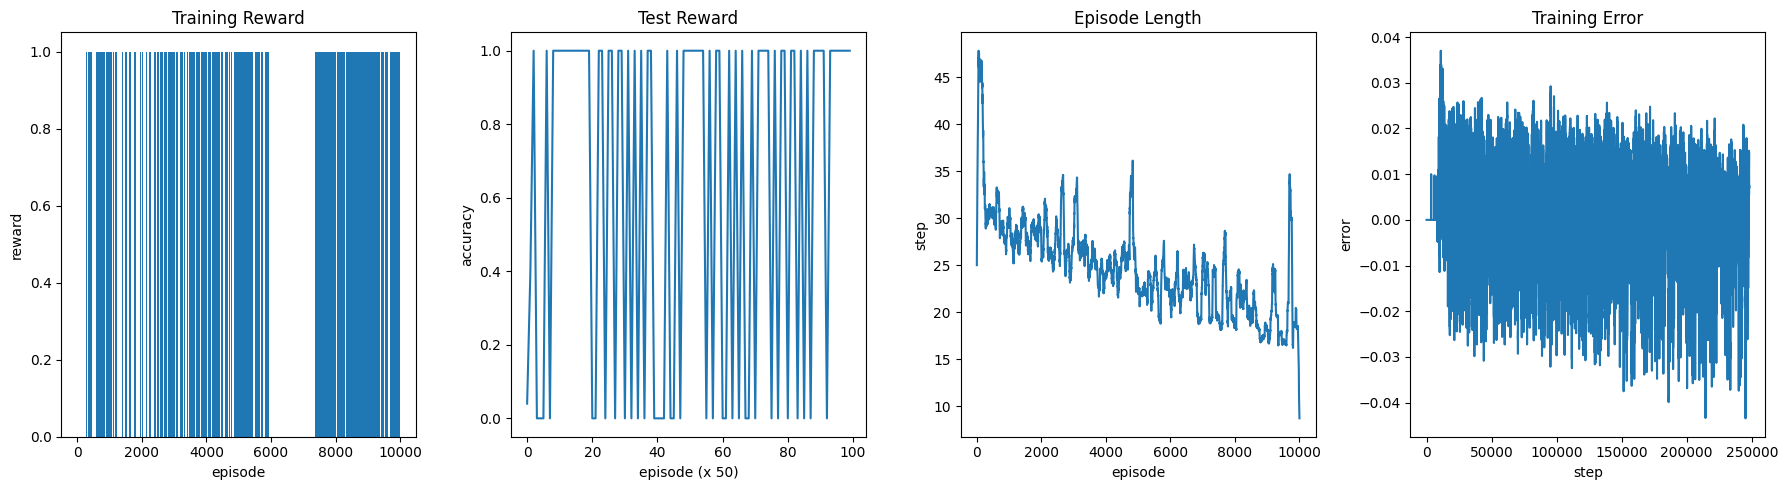

In [89]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_sarsa)), rewards_sarsa)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_sarsa)), accuracies_sarsa)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_sarsa), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_sarsa.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

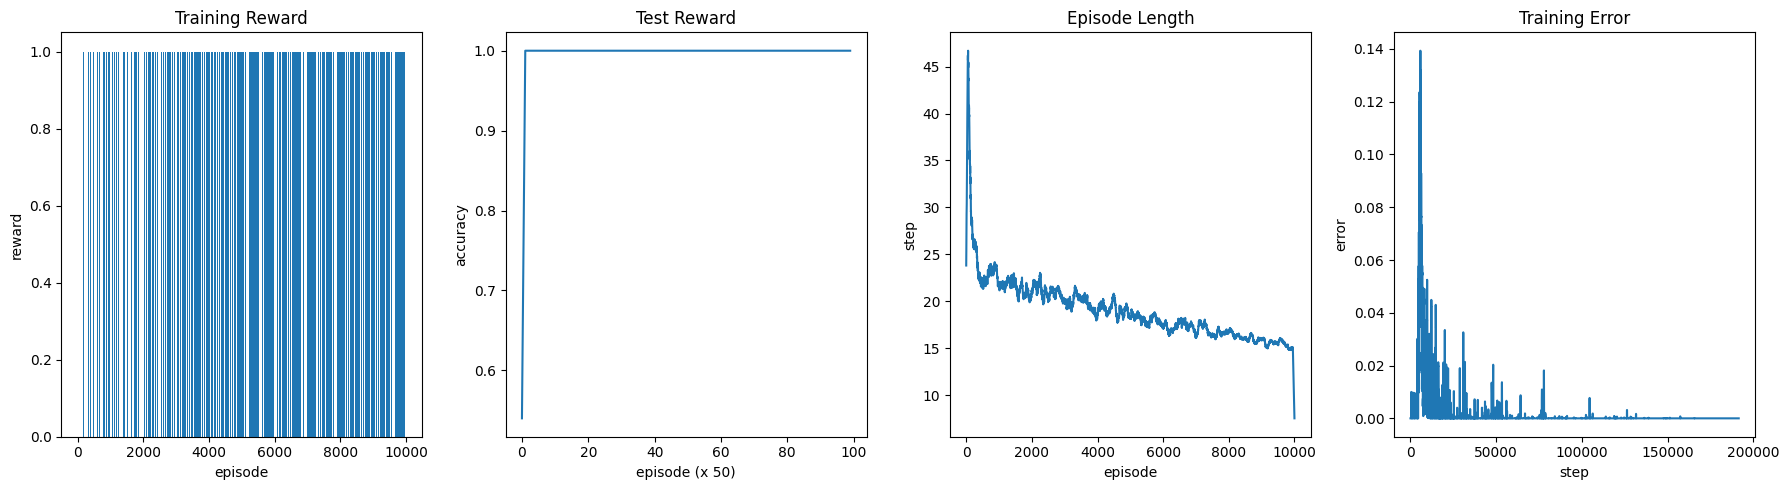

In [90]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_q)), rewards_q)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_q)), accuracies_q)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_q), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_q.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [91]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

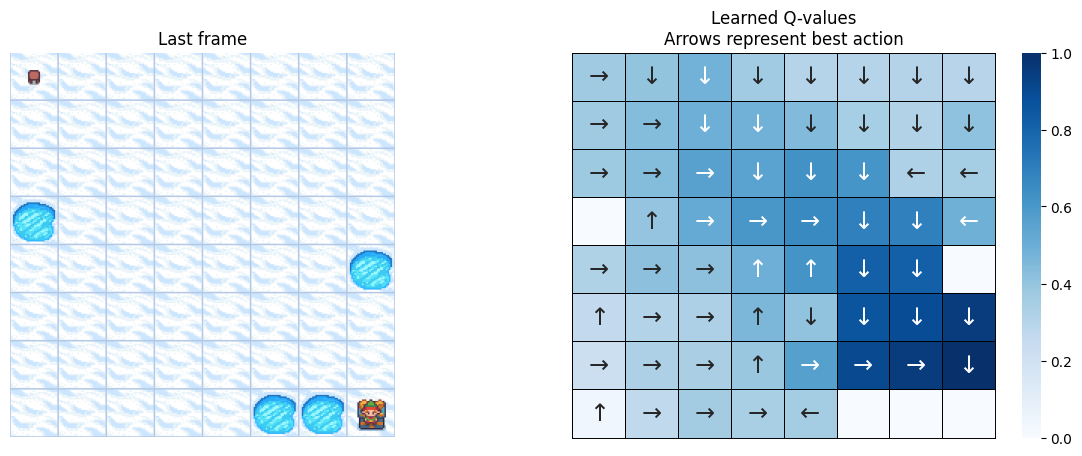

In [92]:
plot_q_values_map(agent_sarsa.get_Q_Table(), env, side_map_size)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


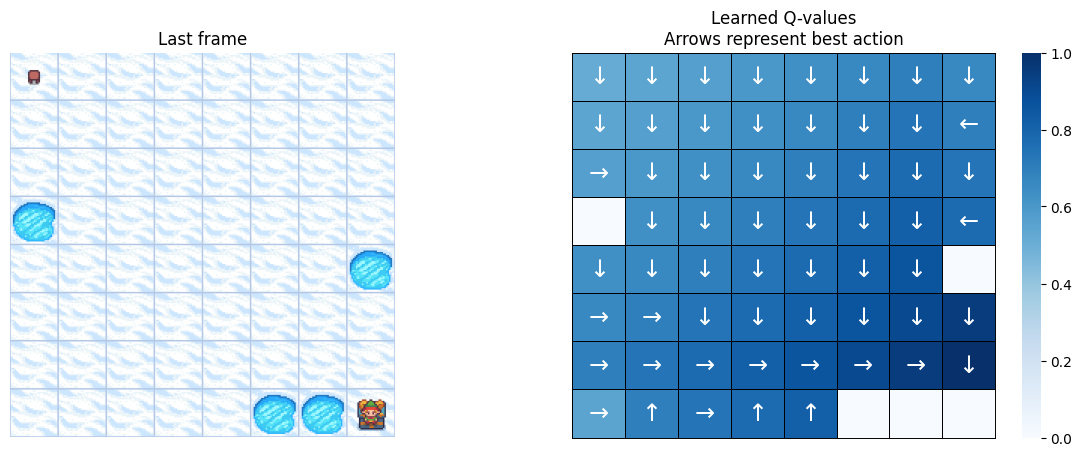

In [93]:
plot_q_values_map(agent_q.get_Q_Table(), env, side_map_size)

### Criando uma estratégia baseada em redes neurais PyTorch

A seguir, avaliamos o desempenho de um agente de Aprendizado por Reforço que utiliza uma rede neural.

In [94]:
# Importing PyTorch neural network (torch.nn) and optimizer (torch.optim)
import torch
import torch.nn as nn
import torch.optim as optim

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>

In [96]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()
        self.input_layer = nn.Linear(state_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    def forward(self, state):
        x = self.input_layer(state)

        x = torch.sigmoid(self.hidden_layer(x))

        return self.output_layer(x)

In [97]:
from torch.nn.functional import one_hot

class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_Q_Network(self):
        return self.model

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def get_one_hot_tensor(self, state):
        # One-hot encode state before passing to the model
        state_tensor = torch.tensor(state, device=self.device, dtype=torch.int64)
        return one_hot(state_tensor, num_classes=self.state_space.n).type(torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def max_eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.max(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_one_hot_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_one_hot_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)

        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [98]:
# hyperparameters
alpha_learning_rate = 0.0001 # @param {type:"number"}
nb_max_episodes = 3000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.n, hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = QLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    is_using_Sarsa = is_using_Sarsa
)

Artificial neural network started with PyTorch
input = 64 , Hidden = 64 , output = 4
Q-learning agent started


In [99]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            model.eval() # Putting the model into evaluation mode (without gradients)
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter


def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        model.eval() # Putting the model into evaluation mode (without gradients)
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()


In [100]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  3%|▎         | 101/3000 [00:11<13:39,  3.54it/s]

step: 5703, episode: 100, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.48666666666666814


  7%|▋         | 203/3000 [00:18<03:16, 14.20it/s]

step: 10005, episode: 200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.47333333333333627


 10%|█         | 306/3000 [00:26<02:01, 22.09it/s]

step: 13455, episode: 300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4600000000000044


 13%|█▎        | 401/3000 [00:39<46:29,  1.07s/it]  

step: 16574, episode: 400, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.44666666666667254


 17%|█▋        | 503/3000 [00:53<14:19,  2.91it/s]

step: 19046, episode: 500, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.4333333333333407


 20%|██        | 602/3000 [00:57<02:12, 18.03it/s]

step: 21571, episode: 600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4200000000000088


 23%|██▎       | 702/3000 [01:01<02:12, 17.32it/s]

step: 23802, episode: 700, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.40666666666667695


 27%|██▋       | 802/3000 [01:06<01:58, 18.55it/s]

step: 25946, episode: 800, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3933333333333451


 30%|███       | 902/3000 [01:11<01:58, 17.67it/s]

step: 28150, episode: 900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3800000000000132


 33%|███▎      | 1000/3000 [01:18<06:11,  5.39it/s]

step: 30217, episode: 1000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.36666666666668135


 37%|███▋      | 1104/3000 [01:24<01:23, 22.83it/s]

step: 32266, episode: 1100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3533333333333495


 40%|████      | 1205/3000 [01:29<01:11, 24.98it/s]

step: 34306, episode: 1200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3400000000000176


 44%|████▎     | 1306/3000 [01:35<01:08, 24.62it/s]

step: 36241, episode: 1300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.32666666666668576


 47%|████▋     | 1407/3000 [01:39<00:56, 28.16it/s]

step: 38166, episode: 1400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3133333333333539


 50%|█████     | 1504/3000 [01:42<00:57, 26.02it/s]

step: 39948, episode: 1500, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.300000000000022


 53%|█████▎    | 1601/3000 [01:49<04:19,  5.38it/s]

step: 41849, episode: 1600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.28666666666669016


 57%|█████▋    | 1704/3000 [01:52<00:53, 24.45it/s]

step: 43583, episode: 1700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2733333333333583


 60%|██████    | 1804/3000 [01:55<00:43, 27.43it/s]

step: 45477, episode: 1800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.26000000000002643


 63%|██████▎   | 1901/3000 [02:00<01:32, 11.86it/s]

step: 47210, episode: 1900, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.24666666666669387


 67%|██████▋   | 2004/3000 [02:06<00:36, 27.56it/s]

step: 49078, episode: 2000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.23333333333335923


 70%|███████   | 2102/3000 [02:09<00:37, 23.70it/s]

step: 50833, episode: 2100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2200000000000246


 73%|███████▎  | 2203/3000 [02:13<00:43, 18.14it/s]

step: 52624, episode: 2200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.20666666666668995


 77%|███████▋  | 2304/3000 [02:18<00:28, 24.64it/s]

step: 54332, episode: 2300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1933333333333553


 80%|████████  | 2406/3000 [02:21<00:46, 12.79it/s]

step: 55980, episode: 2400, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.18000000000002067


 84%|████████▎ | 2507/3000 [02:24<00:16, 29.04it/s]

step: 57673, episode: 2500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.16666666666668603


 87%|████████▋ | 2603/3000 [02:28<00:18, 21.02it/s]

step: 59312, episode: 2600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1533333333333514


 90%|█████████ | 2703/3000 [02:31<00:11, 25.03it/s]

step: 60889, episode: 2700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.14000000000001675


 94%|█████████▎| 2805/3000 [02:34<00:06, 29.21it/s]

step: 62450, episode: 2800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1266666666666821


 97%|█████████▋| 2906/3000 [02:37<00:03, 28.73it/s]

step: 64055, episode: 2900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.11333333333334869


100%|██████████| 3000/3000 [02:40<00:00, 18.70it/s]

step: 65589, episode: 3000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10000000000001544



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


In [101]:
html = render_mp4(after_training)
HTML(html)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Analisamos as métricas da execução de um Agente de aprendizado por reforço com rede neural. Percebe-se que o comprimento dos episódios decresce em uma taxa superior àquelas observadas em abordagens tradicionais. Ademais, o erro de treinamento é muito inferior aos observados anteriormente.

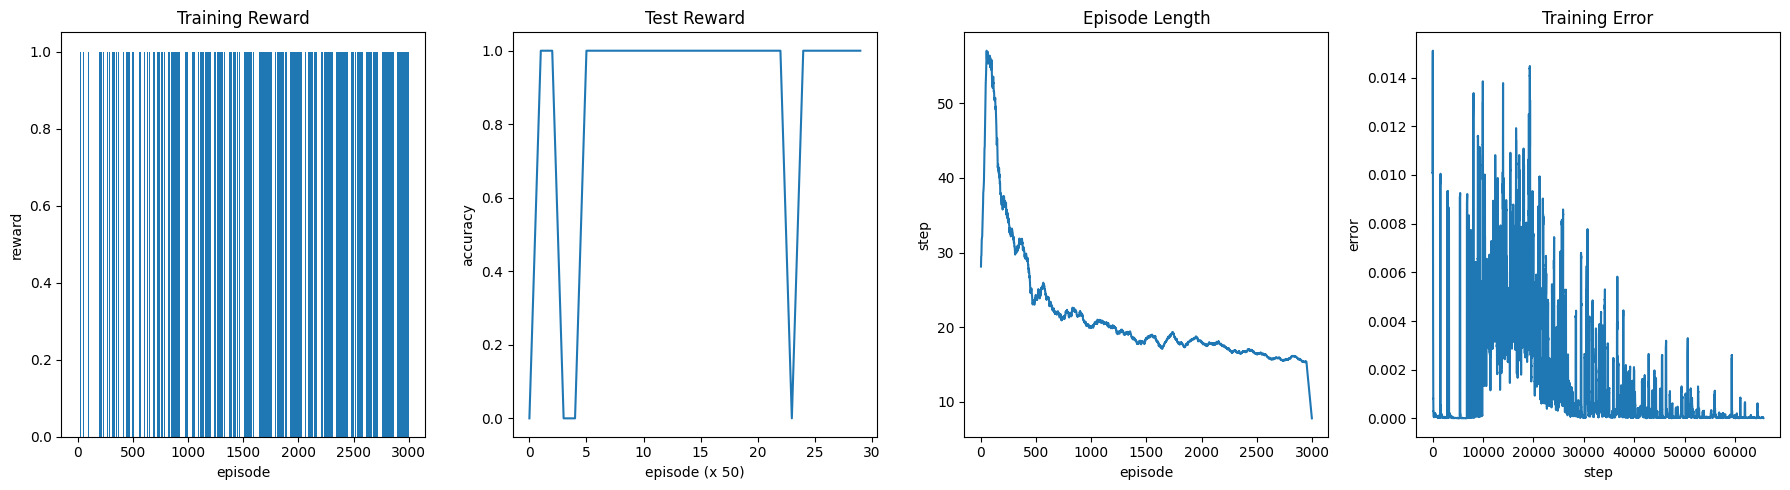

In [102]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [103]:
def qtable_directions_map(qtable_val_max, qtable_best_action, map_size):
    """Get the best learned action & map it to arrows."""
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    for idx, val in enumerate(qtable_best_action.flatten()):
        qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [104]:
def plot_q_values_map(qtable_val_max, qtable_best_action, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable_val_max, qtable_best_action, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

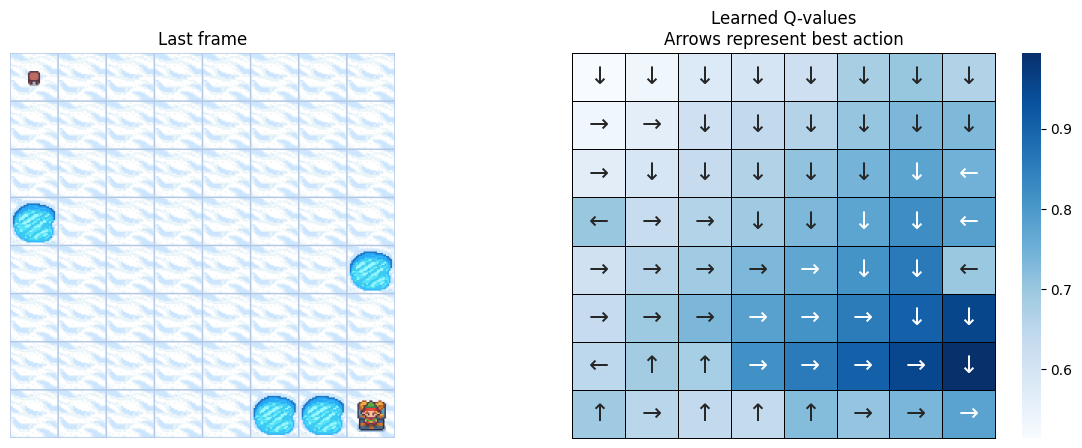

In [105]:
qtable_val_max = np.zeros((side_map_size, side_map_size))
qtable_best_action = np.zeros((side_map_size, side_map_size))
q_network = agent.get_Q_Network()

counter = 0
while counter < side_map_size * side_map_size:
    qtable_val_max[int(counter / side_map_size)][counter % side_map_size] = agent.max_eval_state(counter)
    qtable_best_action[int(counter / side_map_size)][counter % side_map_size] = agent.eval_state(counter)
    counter = counter + 1

plot_q_values_map(qtable_val_max, qtable_best_action, env, side_map_size)

## `Cart Pole`

O Cart-Pole em controlar um carrinho que pode se mover para a esquerda ou para a direita em uma pista reta, com o objetivo de equilibrar um pêndulo invertido  conectado ao carrinho por uma articulação.

O agente precisa aprender a aplicar forças ao carrinho para manter o pêndulo em pé e evitar que ele caia, enquanto também mantém o carrinho dentro dos limites da pista. O agente deve decidir, com base no estado do sistema, quais ações tomar em cada instante para maximizar a recompensa acumulada.


In [106]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.spec

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [108]:
actions = ["push cart to the left", "push cart to the right"]
print ("Actions:", actions)

Actions: ['push cart to the left', 'push cart to the right']


Uma rede neural simples com uma camada com função de ativação sigmoide é criada.

In [115]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()

        # These lines establish the feed-forward part of the neural network used to choose actions
        # Input layer with (one unit for each state variable)
        self.input_layer = nn.Linear(state_size, hidden_size)

        # Hidden layer with a number of hidden neurons
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)

        # Output layer (one unit for each action)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    # Called with either one element to determine the action
    # Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        # Passing the state through the input layer
        x = self.input_layer(state)

        # Passing the input layer output through the hidden layer
        x = torch.relu(self.hidden_layer(x))

        # Passing the hidden layer output through the output layer
        return self.output_layer(x)

In [116]:
class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: np.array,
        action: int,
        reward: float,
        terminated: bool,
        next_state: np.array,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)
        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [117]:
# hyperparameters
alpha_learning_rate = 0.0003 # @param {type:"number"}
nb_max_episodes = 2000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.99 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.shape[0], hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = QLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    is_using_Sarsa = is_using_Sarsa
)

Artificial neural network started with PyTorch
input = 4 , Hidden = 64 , output = 2
Q-learning agent started


In [118]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            model.eval() # Putting the model into evaluation mode (without gradients)
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        model.eval() # Putting the model into evaluation mode (without gradients)
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

In [119]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  5%|▌         | 107/2000 [00:02<00:47, 40.06it/s]

step: 1298, episode: 100, accuracy training: 12.98, accuracy test: 10.08, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:05<00:50, 35.49it/s]

step: 3083, episode: 200, accuracy training: 17.85, accuracy test: 12.48, random move probability: 0.4600000000000044


 15%|█▌        | 304/2000 [00:08<00:59, 28.40it/s]

step: 4759, episode: 300, accuracy training: 16.76, accuracy test: 9.46, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:11<00:49, 32.01it/s]

step: 6255, episode: 400, accuracy training: 14.96, accuracy test: 9.28, random move probability: 0.4200000000000088


 25%|██▌       | 506/2000 [00:13<00:35, 41.69it/s]

step: 7709, episode: 500, accuracy training: 14.54, accuracy test: 10.1, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:17<00:46, 29.86it/s]

step: 10337, episode: 600, accuracy training: 26.28, accuracy test: 10.68, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [00:20<00:44, 29.14it/s]

step: 12194, episode: 700, accuracy training: 18.57, accuracy test: 23.1, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:28<01:38, 12.15it/s]

step: 15937, episode: 800, accuracy training: 37.43, accuracy test: 39.76, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [00:35<01:54,  9.61it/s]

step: 20290, episode: 900, accuracy training: 43.53, accuracy test: 74.68, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [00:43<02:05,  7.98it/s]

step: 24613, episode: 1000, accuracy training: 43.23, accuracy test: 82.12, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [00:55<03:36,  4.15it/s]

step: 31632, episode: 1100, accuracy training: 70.19, accuracy test: 114.68, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:11<03:58,  3.35it/s]

step: 40336, episode: 1200, accuracy training: 87.04, accuracy test: 115.3, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [01:24<04:18,  2.71it/s]

step: 47617, episode: 1300, accuracy training: 72.81, accuracy test: 109.56, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [01:41<02:13,  4.47it/s]

step: 57459, episode: 1400, accuracy training: 98.42, accuracy test: 141.24, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [02:04<04:57,  1.68it/s]

step: 71030, episode: 1500, accuracy training: 135.71, accuracy test: 149.12, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [02:29<01:06,  6.03it/s]

step: 85548, episode: 1600, accuracy training: 145.18, accuracy test: 10.5, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [02:44<01:40,  2.99it/s]

step: 94527, episode: 1700, accuracy training: 89.79, accuracy test: 107.98, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [03:00<00:32,  6.20it/s]

step: 103084, episode: 1800, accuracy training: 85.57, accuracy test: 95.44, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [03:18<00:46,  2.16it/s]

step: 113599, episode: 1900, accuracy training: 105.15, accuracy test: 102.76, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:44<00:00,  8.90it/s]

step: 127047, episode: 2000, accuracy training: 134.48, accuracy test: 426.52, random move probability: 0.10000000000002324



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 500 : push cart to the left , [1.7287912  0.34178716 0.02812556 0.2554747 ] , 1.0 , False , True , {}


In [122]:
html = render_mp4(after_training)
HTML(html)

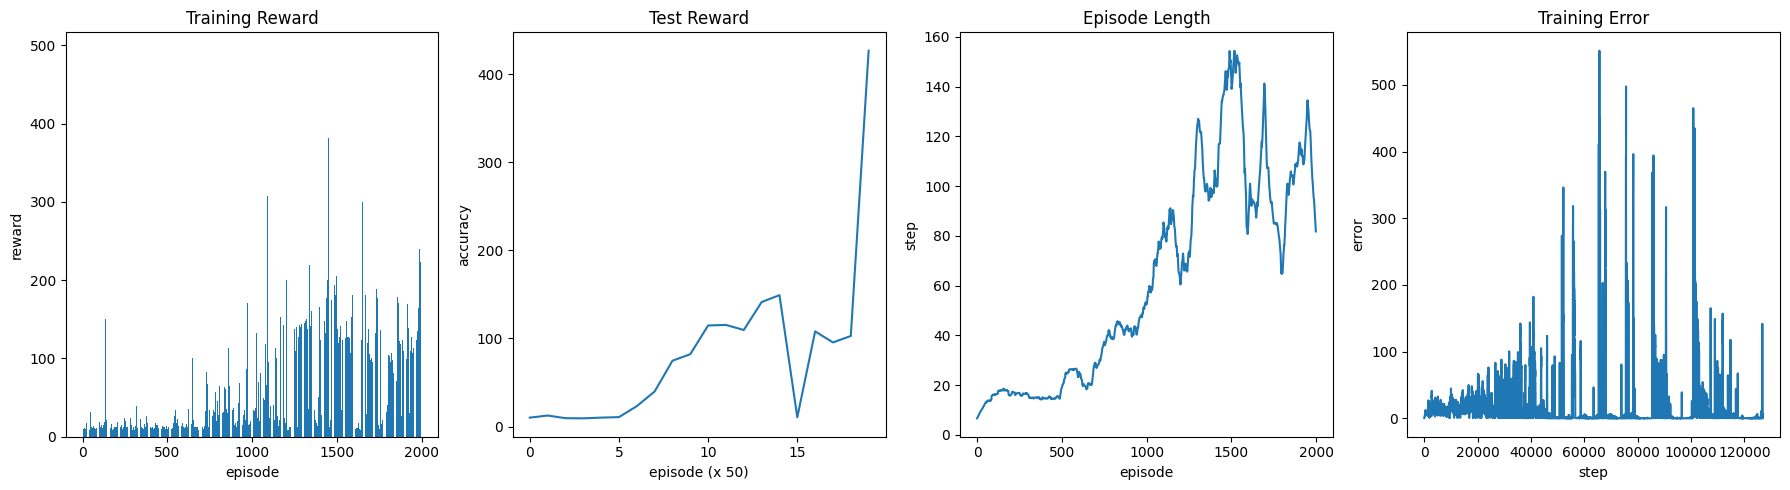

In [121]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [186]:
sum(steps) / len(steps)

63.5235